In [1]:
import os
import sys
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as tdata
import numpy as np
from tqdm import tqdm
import cv2
import wandb

In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..")))

from cancer_classifier.config import MODELS_DIR, RAW_DATA_DIR, PROCESSED_DATA_DIR, INTERIM_DATA_DIR, EXTERNAL_DATA_DIR, CLASSES
from cancer_classifier.processing.image_utils import adjust_image_contrast, resize_image_tensor, normalize_image_tensor, augment_image_tensor, process_dataset, save_processed_images, crop_image
from cancer_classifier.processing.dataset_loader import BrainTumorDataset, preprocess_images, unnormalize

%load_ext autoreload
%autoreload 2

2025-05-18 20:41:39.458 | INFO     | cancer_classifier.config:<module>:11 - PROJ_ROOT path is: /home/ayoubvip/deep-learning-cancer-classifier


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


## Data Preprocessing

### data crop and contract equilazing

In [4]:
img_size = (256, 256)
clip_limit = 2.0
tile_size = (1,1)

# preprocess_images(src_dir=RAW_DATA_DIR, dist_dir=PROCESSED_DATA_DIR,img_size=img_size, clip_limit=clip_limit, tile_size=tile_size)

In [5]:
img_size = (256, 256)
batch_nbr = 16
train_ratio = 0.80
test_ratio = 0.10
val_ratio = 0.10

### data augmentation

In [6]:
transformers = torchvision.transforms.Compose([
    torchvision.transforms.Grayscale(num_output_channels=1),
    torchvision.transforms.Resize(size=img_size),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.RandomVerticalFlip(),
    torchvision.transforms.RandomRotation(10),
    # torchvision.transforms.RandomResizedCrop(size=img_size, scale=(0.8, 1.0)),  #as images are cropped out from surounding black space  to contains only ROI 
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.5], std=[0.5])
])

Dataset = BrainTumorDataset(
    root_dir=PROCESSED_DATA_DIR,
    transform=transformers
)

print(Dataset.class_to_idx)
img_size = (256, 256)
clip_limit = 2.0
tile_size = (1,1)

# preprocess_images(src_dir=RAW_DATA_DIR, dist_dir=PROCESSED_DATA_DIR,img_size=img_size, clip_limit=clip_limit, tile_size=tile_size)

{'brain_glioma': 0, 'brain_menin': 1, 'brain_tumor': 2}


### data spliting 

In [7]:
batch_nbr = 16
train_ratio = 0.80
test_ratio = 0.10
val_ratio = 0.10

train_loader, val_loader, test_loader = Dataset.get_dataloaders(
    batch_size=batch_nbr,
    train_ratio=train_ratio,
    val_ratio=val_ratio
)

# Model Architecture: CNN

In [8]:
def conv_block(out_channels, kernel_size=3,
                stride=1, padding=1, pool_kernel_size=2,
                pool_stride=2, dropout_prob=0.2):
    return nn.Sequential(
        nn.LazyConv2d(out_channels, kernel_size, stride, padding),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Dropout2d(p=dropout_prob),
        nn.MaxPool2d(pool_kernel_size, pool_stride)
    )

In [9]:
fc_dropout_prob = 0.3
class CNNModel(nn.Module):
  def __init__(self, num_classes=CLASSES):
    super(CNNModel, self).__init__()
    
    self.conv_net = nn.Sequential(
        conv_block(64, 3),
        conv_block(128, 5),
        conv_block(256, 5),
        conv_block(512, 3, 2)  
    )
    
    self.fc_layers = nn.Sequential(
           nn.Dropout(fc_dropout_prob),
           nn.LazyLinear(512),
           nn.ReLU(inplace=True),
           nn.Linear(512, num_classes)
        )

  def forward(self, x):
    x = self.conv_net(x)

    x = torch.flatten(x, 1)

    x = self.fc_layers(x)

    return x


In [10]:
CNN_model = CNNModel(num_classes=len(CLASSES)).to(device)
# print(CNN_model)

## Training the model

### defining Loss function, Optimization method, and training parameters

In [11]:
loss_fn = nn.CrossEntropyLoss()
weights_decay = 0.0001
learning_rate = 0.0001
epochs = 10

# optimizer = torch.optim.Adam(
#     CNN_model.parameters(),
#     lr=learning_rate,
#     weight_decay=weights_decay
# ) #->70%

optimizer = torch.optim.AdamW(
    CNN_model.parameters(),
    lr=learning_rate,
    weight_decay=weights_decay
) #->77.4

# optimizer = torch.optim.SGD(
#     CNN_model.parameters(),
#     lr=learning_rate,
#     weight_decay=weights_decay
# ) #> 77.5

In [12]:
def test_loop(dataloader, model, loss_fn, epoch=0):
    # Set the model to evaluation mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.eval()
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0
    true_labels = []
    pred_labels = []
    # Evaluating the model with torch.no_grad() ensures that no gradients are computed during test mode
    # also serves to reduce unnecessary gradient computations and memory usage for tensors with requires_grad=True
    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            true_labels.extend(y.cpu().numpy())
            pred_labels.extend(pred.argmax(1).cpu().numpy())

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    # wandb.log({"epoch": epoch,"accuracy": f"{(100*correct):>0.1f}", "test_loss": test_loss})

    return true_labels, pred_labels, correct, test_loss

In [13]:
from cancer_classifier.modeling.train import train
# import evaluate from cancer_classifier.modeling.evaluate as evaluate
def train_loop(dataloader, model, loss_fn, optimizer, epoch):
    size = len(dataloader.dataset)
    # Set the model to training mode - important for batch normalization and dropout layers
    # Unnecessary in this situation but added for best practices
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        X = X.to(device)
        y = y.to(device) 
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * batch_nbr + len(X)
            # wandb.log({"step":  f"{current:>5d}/{size:>5d}", "train_loss": loss})
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

            

for epoch in tqdm(range(epochs)):
    print("----------------- EPOCH " + str(epoch) + "------------------")
    train_loop(
        dataloader=train_loader,
        model=CNN_model,
        loss_fn=loss_fn,
        optimizer=optimizer,
        epoch=epoch
        )
    true_labels, pred_labels, correct, test_loss =  test_loop(
        dataloader=val_loader,
        model=CNN_model,
        loss_fn=loss_fn,
        epoch=epoch
    )

  0%|          | 0/10 [00:00<?, ?it/s]

----------------- EPOCH 0------------------
loss: 1.083032  [   16/ 4845]
loss: 0.582106  [ 1616/ 4845]
loss: 0.626644  [ 3216/ 4845]
loss: 0.664881  [ 4816/ 4845]


 10%|█         | 1/10 [00:20<03:06, 20.72s/it]

Test Error: 
 Accuracy: 74.5%, Avg loss: 0.580576 

----------------- EPOCH 1------------------
loss: 0.378681  [   16/ 4845]
loss: 0.438596  [ 1616/ 4845]
loss: 0.311683  [ 3216/ 4845]
loss: 0.474514  [ 4816/ 4845]


 20%|██        | 2/10 [00:40<02:39, 19.99s/it]

Test Error: 
 Accuracy: 84.6%, Avg loss: 0.395305 

----------------- EPOCH 2------------------
loss: 0.335608  [   16/ 4845]
loss: 0.170737  [ 1616/ 4845]
loss: 0.423573  [ 3216/ 4845]
loss: 0.393169  [ 4816/ 4845]


 30%|███       | 3/10 [00:59<02:18, 19.77s/it]

Test Error: 
 Accuracy: 89.3%, Avg loss: 0.299183 

----------------- EPOCH 3------------------
loss: 0.473546  [   16/ 4845]
loss: 0.689108  [ 1616/ 4845]
loss: 0.257277  [ 3216/ 4845]
loss: 0.233278  [ 4816/ 4845]


 40%|████      | 4/10 [01:19<01:58, 19.70s/it]

Test Error: 
 Accuracy: 88.9%, Avg loss: 0.272825 

----------------- EPOCH 4------------------
loss: 0.406786  [   16/ 4845]
loss: 0.177311  [ 1616/ 4845]
loss: 0.333519  [ 3216/ 4845]
loss: 0.367923  [ 4816/ 4845]


 50%|█████     | 5/10 [01:39<01:38, 19.70s/it]

Test Error: 
 Accuracy: 91.6%, Avg loss: 0.241013 

----------------- EPOCH 5------------------
loss: 0.147804  [   16/ 4845]
loss: 0.185878  [ 1616/ 4845]
loss: 0.224519  [ 3216/ 4845]
loss: 0.327258  [ 4816/ 4845]


 60%|██████    | 6/10 [01:58<01:18, 19.61s/it]

Test Error: 
 Accuracy: 90.2%, Avg loss: 0.251558 

----------------- EPOCH 6------------------
loss: 0.322536  [   16/ 4845]
loss: 0.312409  [ 1616/ 4845]
loss: 0.160006  [ 3216/ 4845]
loss: 0.181471  [ 4816/ 4845]


 70%|███████   | 7/10 [02:17<00:58, 19.51s/it]

Test Error: 
 Accuracy: 92.1%, Avg loss: 0.206151 

----------------- EPOCH 7------------------
loss: 0.179623  [   16/ 4845]
loss: 0.255468  [ 1616/ 4845]
loss: 0.400564  [ 3216/ 4845]
loss: 0.124772  [ 4816/ 4845]


 80%|████████  | 8/10 [02:37<00:39, 19.61s/it]

Test Error: 
 Accuracy: 89.3%, Avg loss: 0.285773 

----------------- EPOCH 8------------------
loss: 0.473459  [   16/ 4845]
loss: 0.804975  [ 1616/ 4845]
loss: 0.243887  [ 3216/ 4845]
loss: 0.236844  [ 4816/ 4845]


 90%|█████████ | 9/10 [02:57<00:19, 19.56s/it]

Test Error: 
 Accuracy: 93.7%, Avg loss: 0.162301 

----------------- EPOCH 9------------------
loss: 0.145777  [   16/ 4845]
loss: 0.089345  [ 1616/ 4845]
loss: 0.080732  [ 3216/ 4845]
loss: 0.172020  [ 4816/ 4845]


100%|██████████| 10/10 [03:16<00:00, 19.68s/it]

Test Error: 
 Accuracy: 93.9%, Avg loss: 0.156388 



In [16]:
true_labels, pred_labels, correct, test_loss =  test_loop(
    dataloader=val_loader,
    model=CNN_model,
    loss_fn=loss_fn
)

Test Error: 
 Accuracy: 95.5%, Avg loss: 0.121825 



## Evaluating the model

### Covariance Matrix

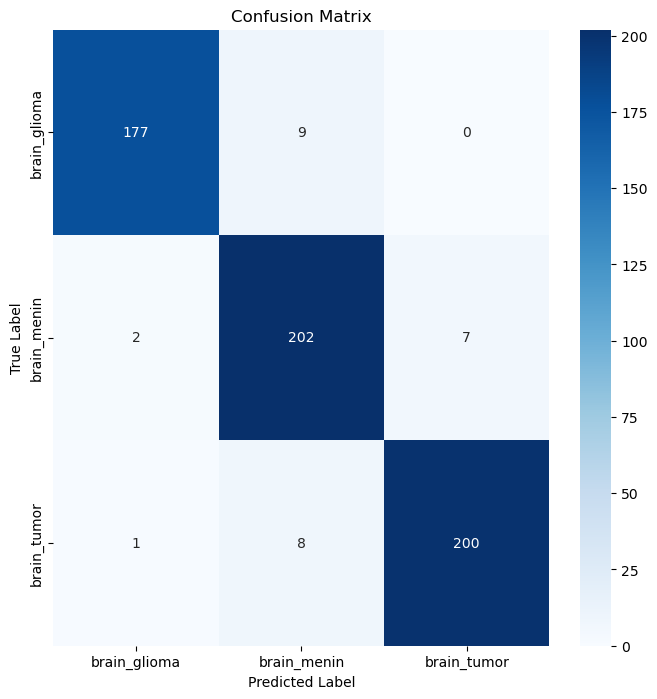

In [19]:
from cancer_classifier.plots import visualize_sample_images,  plot_confusion_matrix
import time

# visualize_sample_images(
#     dataset=Dataset,
# )
plot_confusion_matrix(
    true_classes=true_labels,
    predicted_classes=pred_labels,
    model_name =  time.strftime("%Y-%m-%d_%H-%M-%S") + "_CNN_model_cropped_image" + f"{(100*correct):>0.1f}%"
)

### serializing the model

In [20]:
import time
model_name = f"{(100*correct):>0.1f}%--" + time.strftime("%Y-%m-%d_%H-%M-%S") + "_CNN_model_corped_images.pth"
torch.save(CNN_model.state_dict(), MODELS_DIR / model_name)
print("Saved PyTorch Model State to " +  model_name)

Saved PyTorch Model State to 95.5%--2025-05-18_20-45-36_CNN_model_corped_images.pth
